In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Visualize Data Sample

controls: tensor([0.8500, 0.4754, 0.0000])
high-level command: tensor([1, 0, 0, 0, 0])
traffic light status: tensor([1, 0, 0, 0])


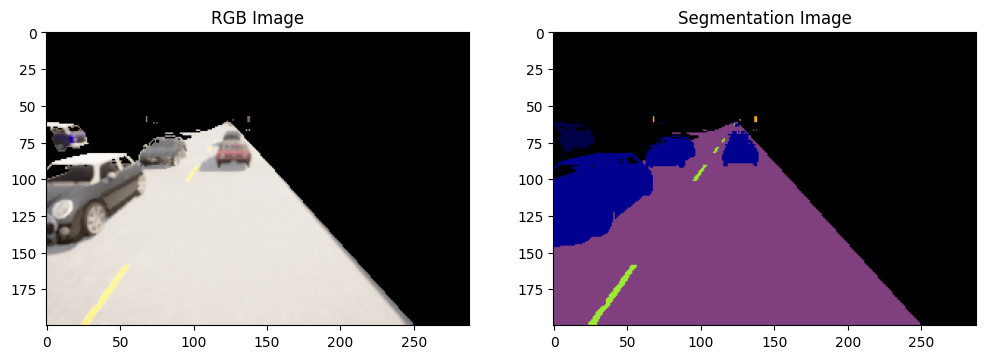

In [2]:
import matplotlib.pyplot as plt
from utils.load_dataset import CARLADataset
from torchvision.transforms import Compose
from utils.preprocess import FilterClassesTransform, ShiftAndAdjustSteer

# set up transforms
filter_transform = FilterClassesTransform(mode='both')
shift_transform = ShiftAndAdjustSteer(shift_fraction=0.1, steer_adjust=1.0)
transforms = Compose([filter_transform, shift_transform])

# create dataset
dataset = CARLADataset('../data/Town01/train', transform=transforms)

# choose a frame to visualize
sample_idx = 590

# fetch sample data
images, speed, hlc, light, controls, distance = dataset[sample_idx]
print(f'controls: {controls}')
print(f'high-level command: {hlc}')
print(f'traffic light status: {light}')
rgb = images[:3, :, :].permute(1, 2, 0)
segmentation = images[3:, :, :].permute(1, 2, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title('RGB Image')

plt.subplot(1, 2, 2)
plt.imshow(segmentation)
plt.title('Segmentation Image')

plt.show()

## Dataset Analysis

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(dataset):
    throttle_vals = []
    brake_vals = []
    steer_vals = []
    speed_vals = []

    for images, speed, hlc, light, controls, distance in dataset:
        throttle_vals.append(controls[0].item())
        brake_vals.append(controls[2].item())
        steer_vals.append(controls[1].item())
        speed_vals.append(speed.item())

    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    axs[0, 0].hist(throttle_vals, bins=100)
    axs[0, 0].set_title('Throttle')

    axs[0, 1].hist(brake_vals, bins=100)
    axs[0, 1].set_title('Brake')

    axs[1, 0].hist(steer_vals, bins=100)
    axs[1, 0].set_title('Steer')

    axs[1, 1].hist(speed_vals, bins=100)
    axs[1, 1].set_title('Speed')

    plt.show()


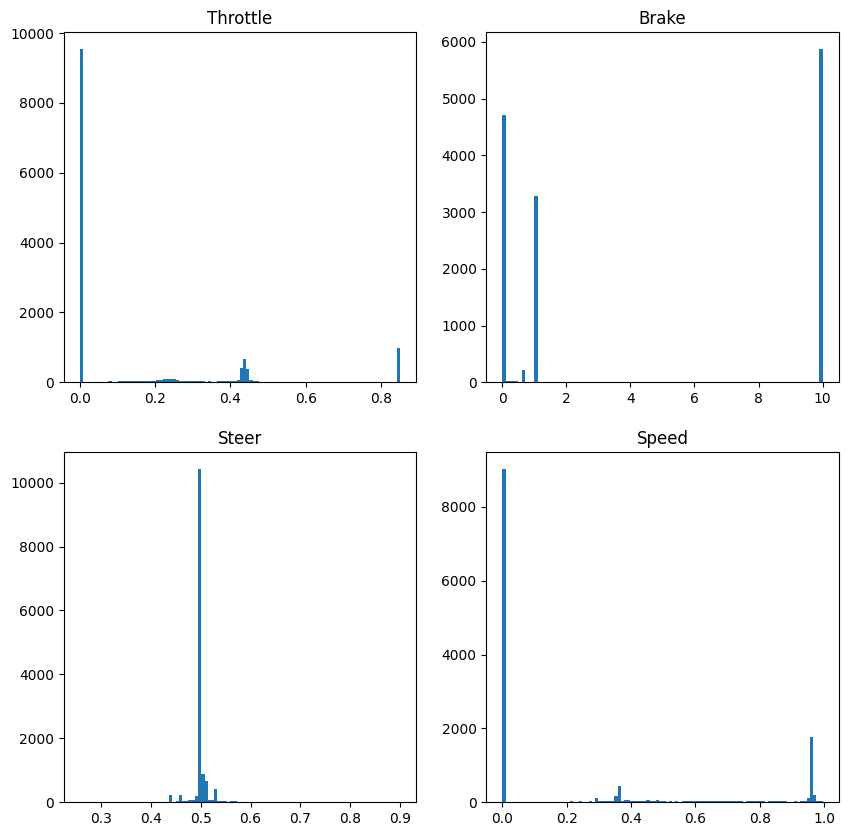

In [6]:
from utils.load_dataset import CARLADataset
dataset = CARLADataset("../data/Town01/train")
plot_histogram(dataset)

## Load Dataset

In [4]:
from utils.load_dataset import CARLADataset
from torch.utils.data import DataLoader

def load_data(batch_size, dataset_path, transform, one_hot, combined_control):
    train_data_dir = f"{dataset_path}train"
    val_data_dir = f"{dataset_path}val"

    train_dataset = CARLADataset(train_data_dir, transform=transform, one_hot=one_hot, combined_control=combined_control)
    val_dataset = CARLADataset(val_data_dir, transform=transform, one_hot=one_hot, combined_control=combined_control)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    return train_dataloader, val_dataloader

## Train Model

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# weights = torch.tensor([2.0, 1.0, 5.0])
# weights = weights.to(device)

# def weighted_l1_loss(y_pred, y_true):
#     l1_loss = torch.abs(y_pred - y_true)
#     return torch.sum(l1_loss * weights.expand_as(y_pred)) / y_pred.size(0)

def train_model(model, train_dataloader, val_dataloader, epochs, device, lr=0.001):
    # loss function and optimizer
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # torch.autograd.set_detect_anomaly(True)

    train_losses = []
    val_losses = []
    # loop over the dataset

    for epoch in range(epochs):
        model.train()

        running_loss = 0.0

        # Training loop
        for i, data in enumerate(train_dataloader):
            # Get the inputs and move them to the appropriate device (CPU or GPU)
            img, speed, hlc, light, controls, distance = data
            img = img.to(device)
            speed = speed.to(device)
            hlc = hlc.to(device)
            light = light.to(device)
            controls = controls.to(device)
            distance = distance.to(device)

            # forward pass
            outputs = model(img, speed, hlc, light, distance)
            #loss = criterion(outputs, controls)
            loss = criterion(outputs, controls)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

            if i % 200 == 199:  # Print every 200 mini-batches
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}')

        # compute average loss
        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_dataloader):
                img, speed, hlc, light, controls, distance = data
                img = img.to(device)
                speed = speed.to(device)
                hlc = hlc.to(device)
                light = light.to(device)
                controls = controls.to(device)
                distance = distance.to(device)

                outputs = model(img, speed, hlc, light, distance)
                #loss = criterion(outputs, controls)
                loss = criterion(outputs, controls)

                running_loss += loss.item()

        # Compute the average loss
        val_loss = running_loss / len(val_dataloader)
        val_losses.append(val_loss)


        # print statistics
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # save model
        torch.save(model.state_dict(), f'model_checkpoint_{epoch}.pth')

    # save the losses for analysis
    torch.save({'train_losses': train_losses, 'val_losses': val_losses}, 'losses.pth')

In [8]:
# def train_model(model, train_dataloader, val_dataloader, epochs, device):
#     # loss function and optimizer
#     criterion = torch.nn.L1Loss()
#     optimizer = torch.optim.Adam(model.parameters())

#     # torch.autograd.set_detect_anomaly(True)

#     train_losses = []
#     val_losses = []
#     # loop over the dataset

#     for epoch in range(epochs):
#         model.train()

#         running_loss = 0.0

#         # Training loop
#         for i, data in enumerate(train_dataloader):
#             # Get the inputs and move them to the appropriate device (CPU or GPU)
#             img, speed, hlc, controls = data
#             img = img.to(device)
#             speed = speed.to(device)
#             hlc = hlc.to(device)
#             controls = controls.to(device)

#             # forward pass
#             outputs = model(img, speed, hlc)
#             loss = criterion(outputs, controls)

#             # backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Print statistics
#             running_loss += loss.item()

#             if i % 200 == 199:  # Print every 200 mini-batches
#                 print(f'Epoch: {epoch + 1}, Batch: {i + 1}')

#         # compute average loss
#         train_loss = running_loss / len(train_dataloader)
#         train_losses.append(train_loss)

#         # validation
#         model.eval()
#         running_loss = 0.0
#         with torch.no_grad():
#             for i, data in enumerate(val_dataloader):
#                 img, speed, hlc, controls = data
#                 img = img.to(device)
#                 speed = speed.to(device)
#                 hlc = hlc.to(device)
#                 controls = controls.to(device)

#                 outputs = model(img, speed, hlc)
#                 loss = criterion(outputs, controls)

#                 running_loss += loss.item()

#         # Compute the average loss
#         val_loss = running_loss / len(val_dataloader)
#         val_losses.append(val_loss)


#         # print statistics
#         print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

#         # save model
#         torch.save(model.state_dict(), f'model_checkpoint_{epoch}.pth')

#     # save the losses for analysis
#     torch.save({'train_losses': train_losses, 'val_losses': val_losses}, 'losses.pth')

In [5]:
from utils.ModifiedDeepestLSTMTinyPilotNet import PilotNetEmbeddingNoLight, PilotNetOneHot, PilotNetOneHot, PilotNetOneHotDistance, PilotNetOneHotNoLight
from torchvision.transforms import Compose
from utils.preprocess import FilterClassesTransform, ShiftAndAdjustSteer

# Instantiate the transformations
filter_transform = FilterClassesTransform(mode='both', classes_to_keep = [1, 7, 12, 13, 14, 15, 16, 17, 18, 19, 24]) # keep traffic light
#filter_transform = FilterClassesTransform(mode='both', classes_to_keep = [1, 12, 13, 14, 15, 16, 17, 18, 19, 24]) # no traffic light
shift_transform = ShiftAndAdjustSteer(shift_fraction=0.1, steer_adjust=1.0)
transforms = Compose([filter_transform, shift_transform])

# Set the batch size and number of epochs
batch_size = 32
epochs = 20

#transform = FilterClassesTransform(mode='both')
transform = None
one_hot = True
combined_control = True
# Load the data
train_dataloader, val_dataloader = load_data(batch_size, '../data/Town01/', transform=transforms, one_hot=one_hot, combined_control=combined_control)
print("loaded data")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize the model and move it to the device
#model = PilotNetOneHotNoLight((288, 200, 6), 3, 4)
#model = PilotNetEmbeddingNoLight((288, 200, 6), 3, 4)
#model = PilotNetOneHot((288, 200, 6), 3, 4, 4)
#model = PilotNetOneHot((288, 200, 6), 2, 5, 4) # combined control
model = PilotNetOneHotDistance((288, 200, 6), 2, 5, 4) # combined control
#model.load_state_dict(torch.load("models/v8.2.3_10 epochs.pth"))
model.to(device)

# Train the model
train_model(model, train_dataloader, val_dataloader, epochs, device, lr=0.001)


loaded data
cuda
Epoch: 1, Batch: 200
Epoch: 1, Batch: 400
Epoch: 1, Batch: 600
Epoch: 1, Batch: 800
Epoch: 1, Batch: 1000
Epoch 1, Train Loss: 1.274304134488341, Val Loss: 1.2627883485539888
Epoch: 2, Batch: 200
Epoch: 2, Batch: 400
Epoch: 2, Batch: 600
Epoch: 2, Batch: 800
Epoch: 2, Batch: 1000
Epoch 2, Train Loss: 1.2703881742215957, Val Loss: 1.263707774877369
Epoch: 3, Batch: 200
Epoch: 3, Batch: 400
Epoch: 3, Batch: 600
Epoch: 3, Batch: 800
Epoch: 3, Batch: 1000
Epoch 3, Train Loss: 1.2686982237140574, Val Loss: 1.2097703114868357
Epoch: 4, Batch: 200
Epoch: 4, Batch: 400
Epoch: 4, Batch: 600
Epoch: 4, Batch: 800
Epoch: 4, Batch: 1000
Epoch 4, Train Loss: 1.189501265038165, Val Loss: 1.1828928356995592
Epoch: 5, Batch: 200
Epoch: 5, Batch: 400
Epoch: 5, Batch: 600
Epoch: 5, Batch: 800
Epoch: 5, Batch: 1000
Epoch 5, Train Loss: 1.185237096552783, Val Loss: 1.1809112728580546
Epoch: 6, Batch: 200
Epoch: 6, Batch: 400
Epoch: 6, Batch: 600
Epoch: 6, Batch: 800
Epoch: 6, Batch: 1000
E

### Plot losses

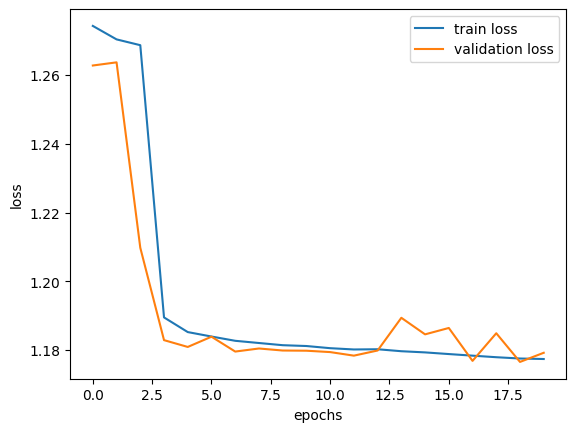

In [6]:
# Load the tensor from the file
loss_history = torch.load('losses.pth')

# Now you can use this tensor, print it, plot it, etc.
train_l1 = loss_history['train_losses']
val_l1 = loss_history['val_losses']

# # Load the tensor from the file
# loss_history2 = torch.load('losses.pth')

# # # Now you can use this tensor, print it, plot it, etc.
# train_l2 = loss_history2['train_losses']
# val_l2 = loss_history2['val_losses']

train_losses = train_l1
val_losses = val_l1

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.title('Loss')
plt.legend()

## Predictions Visualization

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PilotNetOneHotDistance((288, 200, 6), 2, 5, 4)
model.load_state_dict(torch.load("model_checkpoint_19.pth"))
model = model.to(device)
model.eval()

# Load the validation dataset
val_dataset = CARLADataset("../data/train/")
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

# Get a batch of validation data
dataiter = iter(val_dataloader)
num_batches = len(val_dataloader)
selected_batch = random.randint(0, 100)

for i in range(selected_batch):
    data = next(dataiter)
images, speeds, controls_true = data

# Predict controls with the model
controls_pred = model(images.to(device), speeds.to(device))


# Convert tensors to numpy arrays for printing
with torch.no_grad():
    controls_true = controls_true.numpy()
    controls_pred = controls_pred.cpu().detach().numpy()

# Print true and predicted controls for each sample
for i in range(4):
    print(f"Sample {i+1}")
    print(f"True controls: throttle {controls_true[i, 0]}, brake {controls_true[i, 2]}, steer {controls_true[i, 1]}")
    print(f"Predicted controls: throttle {controls_pred[i, 0]}, brake {controls_pred[i, 2]}, steer {controls_pred[i, 1]}")
    print()

# Display images
segmentation_images = images[:, 3:, :, :]
grid_img = make_grid(segmentation_images, nrow=2)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


StopIteration: 